Import Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [5]:
import re

In [6]:

df['hp'] = df['engine'].apply(lambda x: x.split()[0][:-2] if 'HP' in x.split()[0] else np.nan).astype('float')
df['engine_capacity'] =  df['engine'].apply(lambda x: re.findall('\d[.]\d{0,2}',re.findall('\d+[.]?\d*[\s]?l', x.lower())[0])[0] if re.search('\d+[.]?\d*[\s]?l', x.lower()) else np.nan).astype('float')
df['cylinders'] =  df['engine'].apply(lambda x: re.findall('\d{1,2}',re.findall('\d{1,2}[\s]?cyl', x.lower())[0])[0] if re.search('\d{1,2}[\s]?cyl', x.lower()) else re.findall('\d{1,2}',re.findall('[v,h,i]\d{1,2}', x.lower())[0])[0] if re.search('[v,h,i]\d{1,2}', x.lower())  else np.nan).astype('float')
df['transmission_type'] = df['transmission'].apply(lambda x : 'AT' if 'automatic' in x.lower() or 'a/t' in x.lower() or 'cvt' in x.lower() or 'dct' in x.lower() else 'MT' if 'm/t' in x.lower() or 'manual' in x.lower() else 'Unknown')
def get_fuel_from_engine(row):
    if (row['fuel_type'] == 'not supported' or row['fuel_type'] == '–'or pd.isna( row['fuel_type'])):
        if 'gasoline' in row['engine'].lower():
            return 'Gasoline'
        elif 'diesel' in row['engine'].lower():
            return 'Diesel'
        elif 'electric' in row['engine'].lower() or 'battery' in row['engine'].lower() or 'motor' in row['engine'].lower() or 'tesla' in row['brand'].lower() or re.search('\d{1,4}ah',row['engine'].lower()) or re.search('\d{1,4}kw',row['engine'].lower()):   
            return 'Electric'
        elif 'petrol' in row['engine'].lower(): 
            return 'Gasoline'
        elif 'hybrid' in row['engine'].lower():
            return 'Hybrid'
        elif 'flex' in row['engine'].lower():
            return 'Flex'
        else:
            return 'Unknown'
    else:
        return row['fuel_type']
df['fuel_type'] = df.apply(get_fuel_from_engine, axis =1)
df['fuel_type'] = df['fuel_type'].replace(['E85 Flex Fuel', '–', 'Plug-In Hybrid'], ['Flex','Unknown','Hybrid'])
df['model_w\o_trim'] = df.apply(lambda row: row['brand']+' '+' '.join(row['model'].split()[:2]) if len(row['model'].split())>2 else row['brand']+' '+row['model'].split()[0], axis = 1)
df['trim'] = df['model'].apply(lambda x: ' '.join(x.split()[2:]) if len(x.split())>2 else x.split()[1] if len(x.split())==2 else 'Unknown')
df['accident'].fillna("Unknown", inplace = True)
df['clean_title'].fillna("Unknown", inplace= True)

Bin exterior and interior colors

In [ ]:
df['ext_col_len'] = df['ext_col'].apply(lambda x: len(x.split()))
base_colors = df[df['ext_col_len'] == 1]['ext_col'].value_counts()[:15].index.to_list()
base_colors.remove('–')
base_colors.remove('Metallic')

In [ ]:
def map_color(x, base_colors):
    if x in base_colors:
        return x
    match = next((y for y in base_colors if re.search(y, x)), None)
    return match if match else 'Niche'

In [ ]:
df['base_ext_color'] = df['ext_col'].apply(lambda x: map_color(x, base_colors))
df['int_col_len'] = df['int_col'].apply(lambda x: len(x.split()))
base_colors_int = df[df['int_col_len'] == 1]['int_col'].value_counts()[:6].index.to_list()
df['base_int_color'] = df['int_col'].apply(lambda x: map_color(x, base_colors_int))


Impute horse power through a series of steps

In [ ]:
null_hp = df[df['hp'].isnull()][['brand','model','model_year']].drop_duplicates()
null_hp = df.merge(null_hp, on = ['brand','model','model_year'])
null_hp_impute = null_hp.groupby(['brand','model','model_year'])['hp'].mean().reset_index().rename(columns = {'hp':'hp_x'})
null_hp_impute2 = null_hp.groupby(['brand','model'])['hp'].mean().reset_index().rename(columns = {'hp':'hp_y'})
null_hp_impute3 = df[['engine_capacity','cylinders','hp']].groupby(['engine_capacity','cylinders'])['hp'].mean().reset_index().rename(columns = {'hp':'hp_z'})
null_hp_impute4 = df[['engine_capacity','hp']].groupby(['engine_capacity'])['hp'].mean().reset_index().rename(columns = {'hp':'hp_zz'})
df = df.merge(null_hp_impute , on = ['brand','model','model_year'], how = 'left').merge(null_hp_impute2, on = ['brand','model'], how = 'left' ).merge(null_hp_impute3, on = ['engine_capacity','cylinders'], how = 'left').merge(null_hp_impute4, on = ['engine_capacity'], how = 'left')
df['hp_final'] = df.apply(lambda row: row['hp'] if not pd.isna(row['hp']) else (row['hp_x'] if not pd.isna(row['hp_x']) else (row['hp_y'] if not pd.isna(row['hp_y']) else (row['hp_z'] if not pd.isna(row['hp_z']) else row['hp_zz']))), axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 188533 non-null  int64  
 1   brand              188533 non-null  object 
 2   model              188533 non-null  object 
 3   model_year         188533 non-null  int64  
 4   milage             188533 non-null  int64  
 5   fuel_type          188533 non-null  object 
 6   engine             188533 non-null  object 
 7   transmission       188533 non-null  object 
 8   ext_col            188533 non-null  object 
 9   int_col            188533 non-null  object 
 10  accident           186081 non-null  object 
 11  clean_title        167114 non-null  object 
 12  price              188533 non-null  int64  
 13  hp                 155274 non-null  float64
 14  engine_capacity    181835 non-null  float64
 15  cylinders          174150 non-null  float64
 16  tr

Catch hold of outliers

In [18]:
temp_df = df[['brand','model_w\o_trim', 'price']].groupby(['brand','model_w\o_trim']).agg(mean_price_model=('price', 'mean'), model_count=('price', 'count')).reset_index().sort_values(by=['brand','mean_price_model','model_count','model_w\o_trim',])
temp_df['model_count'] = temp_df['model_count'].apply(lambda x: 'single' if x == 1 else 'low' if x>1 and x <10 else 'med' if x>10 and x <20 else 'high')
brand_code = []
unique_brands = temp_df['brand'].unique().tolist()

for n in unique_brands:
    brand_code.extend([unique_brands.index(n)]*temp_df['brand'].value_counts()[n])
temp_df['brand_code'] = brand_code

mc = [list(range(brand_code.count(n))) for n in set(brand_code)]
mc_z = [(m - np.mean(m))/np.std(m) for m in mc]
model_code = []
for m in mc_z:
    model_code.extend(m)
temp_df['model_code'] = model_code
df = df.merge(temp_df, how = 'left')

C:\Users\Richard\AppData\Local\Temp\ipykernel_30236\3851333892.py:11: RuntimeWarning: invalid value encountered in divide
  mc_z = [(m - np.mean(m))/np.std(m) for m in mc]


In [29]:
df['temp_model'] = df['model'].apply(lambda x: ' '.join(x.split()[:2]) if len(x.split())>2 else x.split()[0])
model_grp = df[['temp_model','brand','price']].groupby(['temp_model','brand']).size().reset_index().rename(columns = {0:'size'})

In [71]:
model_grp

,temp_model,brand,size
0,124 Spider,FIAT,5
1,128,BMW,19
2,135,BMW,135
3,1500,RAM,2252
4,1500 Big,RAM,656
...,...,...,...
1009,i8,BMW,55
1010,tC,Scion,15
1011,tC Anniversary,Scion,38
1012,tC Release,Scion,20


In [79]:
model_grp['temp_model'].value_counts()[model_grp['temp_model'].value_counts()>1].index
max_size = model_grp.groupby('temp_model')['size'].max().reset_index().rename(columns = {'size':'max_size'})
model_grp = model_grp.merge(max_size)
model_grp['outlier'] = model_grp.apply(lambda row: row['size']!= row['max_size'],axis = 1) 

In [81]:
df = df.merge(model_grp[['temp_model','brand', 'outlier']], on = ['temp_model','brand'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 188533 non-null  int64  
 1   brand              188533 non-null  object 
 2   model              188533 non-null  object 
 3   model_year         188533 non-null  int64  
 4   milage             188533 non-null  int64  
 5   fuel_type          188533 non-null  object 
 6   engine             188533 non-null  object 
 7   transmission       188533 non-null  object 
 8   ext_col            188533 non-null  object 
 9   int_col            188533 non-null  object 
 10  accident           188533 non-null  object 
 11  clean_title        188533 non-null  object 
 12  price              188533 non-null  int64  
 13  hp                 155274 non-null  float64
 14  engine_capacity    181835 non-null  float64
 15  cylinders          174150 non-null  float64
 16  tr

In [20]:
model_year_map = df['model_year'].apply(lambda x: x//10)

Distribution of brand-model outliers across the price range for each brand

C:\Users\Richard\AppData\Local\Temp\ipykernel_30236\3309703882.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(df_sorted[df_sorted['outlier'] == True],x = 'price' ,y= 'brand', color = 'red', style = 'model_count', markers = shape_map, size = model_year_map, alpha = 0.8, palette= 'RdYlBu' )


<Axes: xlabel='price', ylabel='brand'>

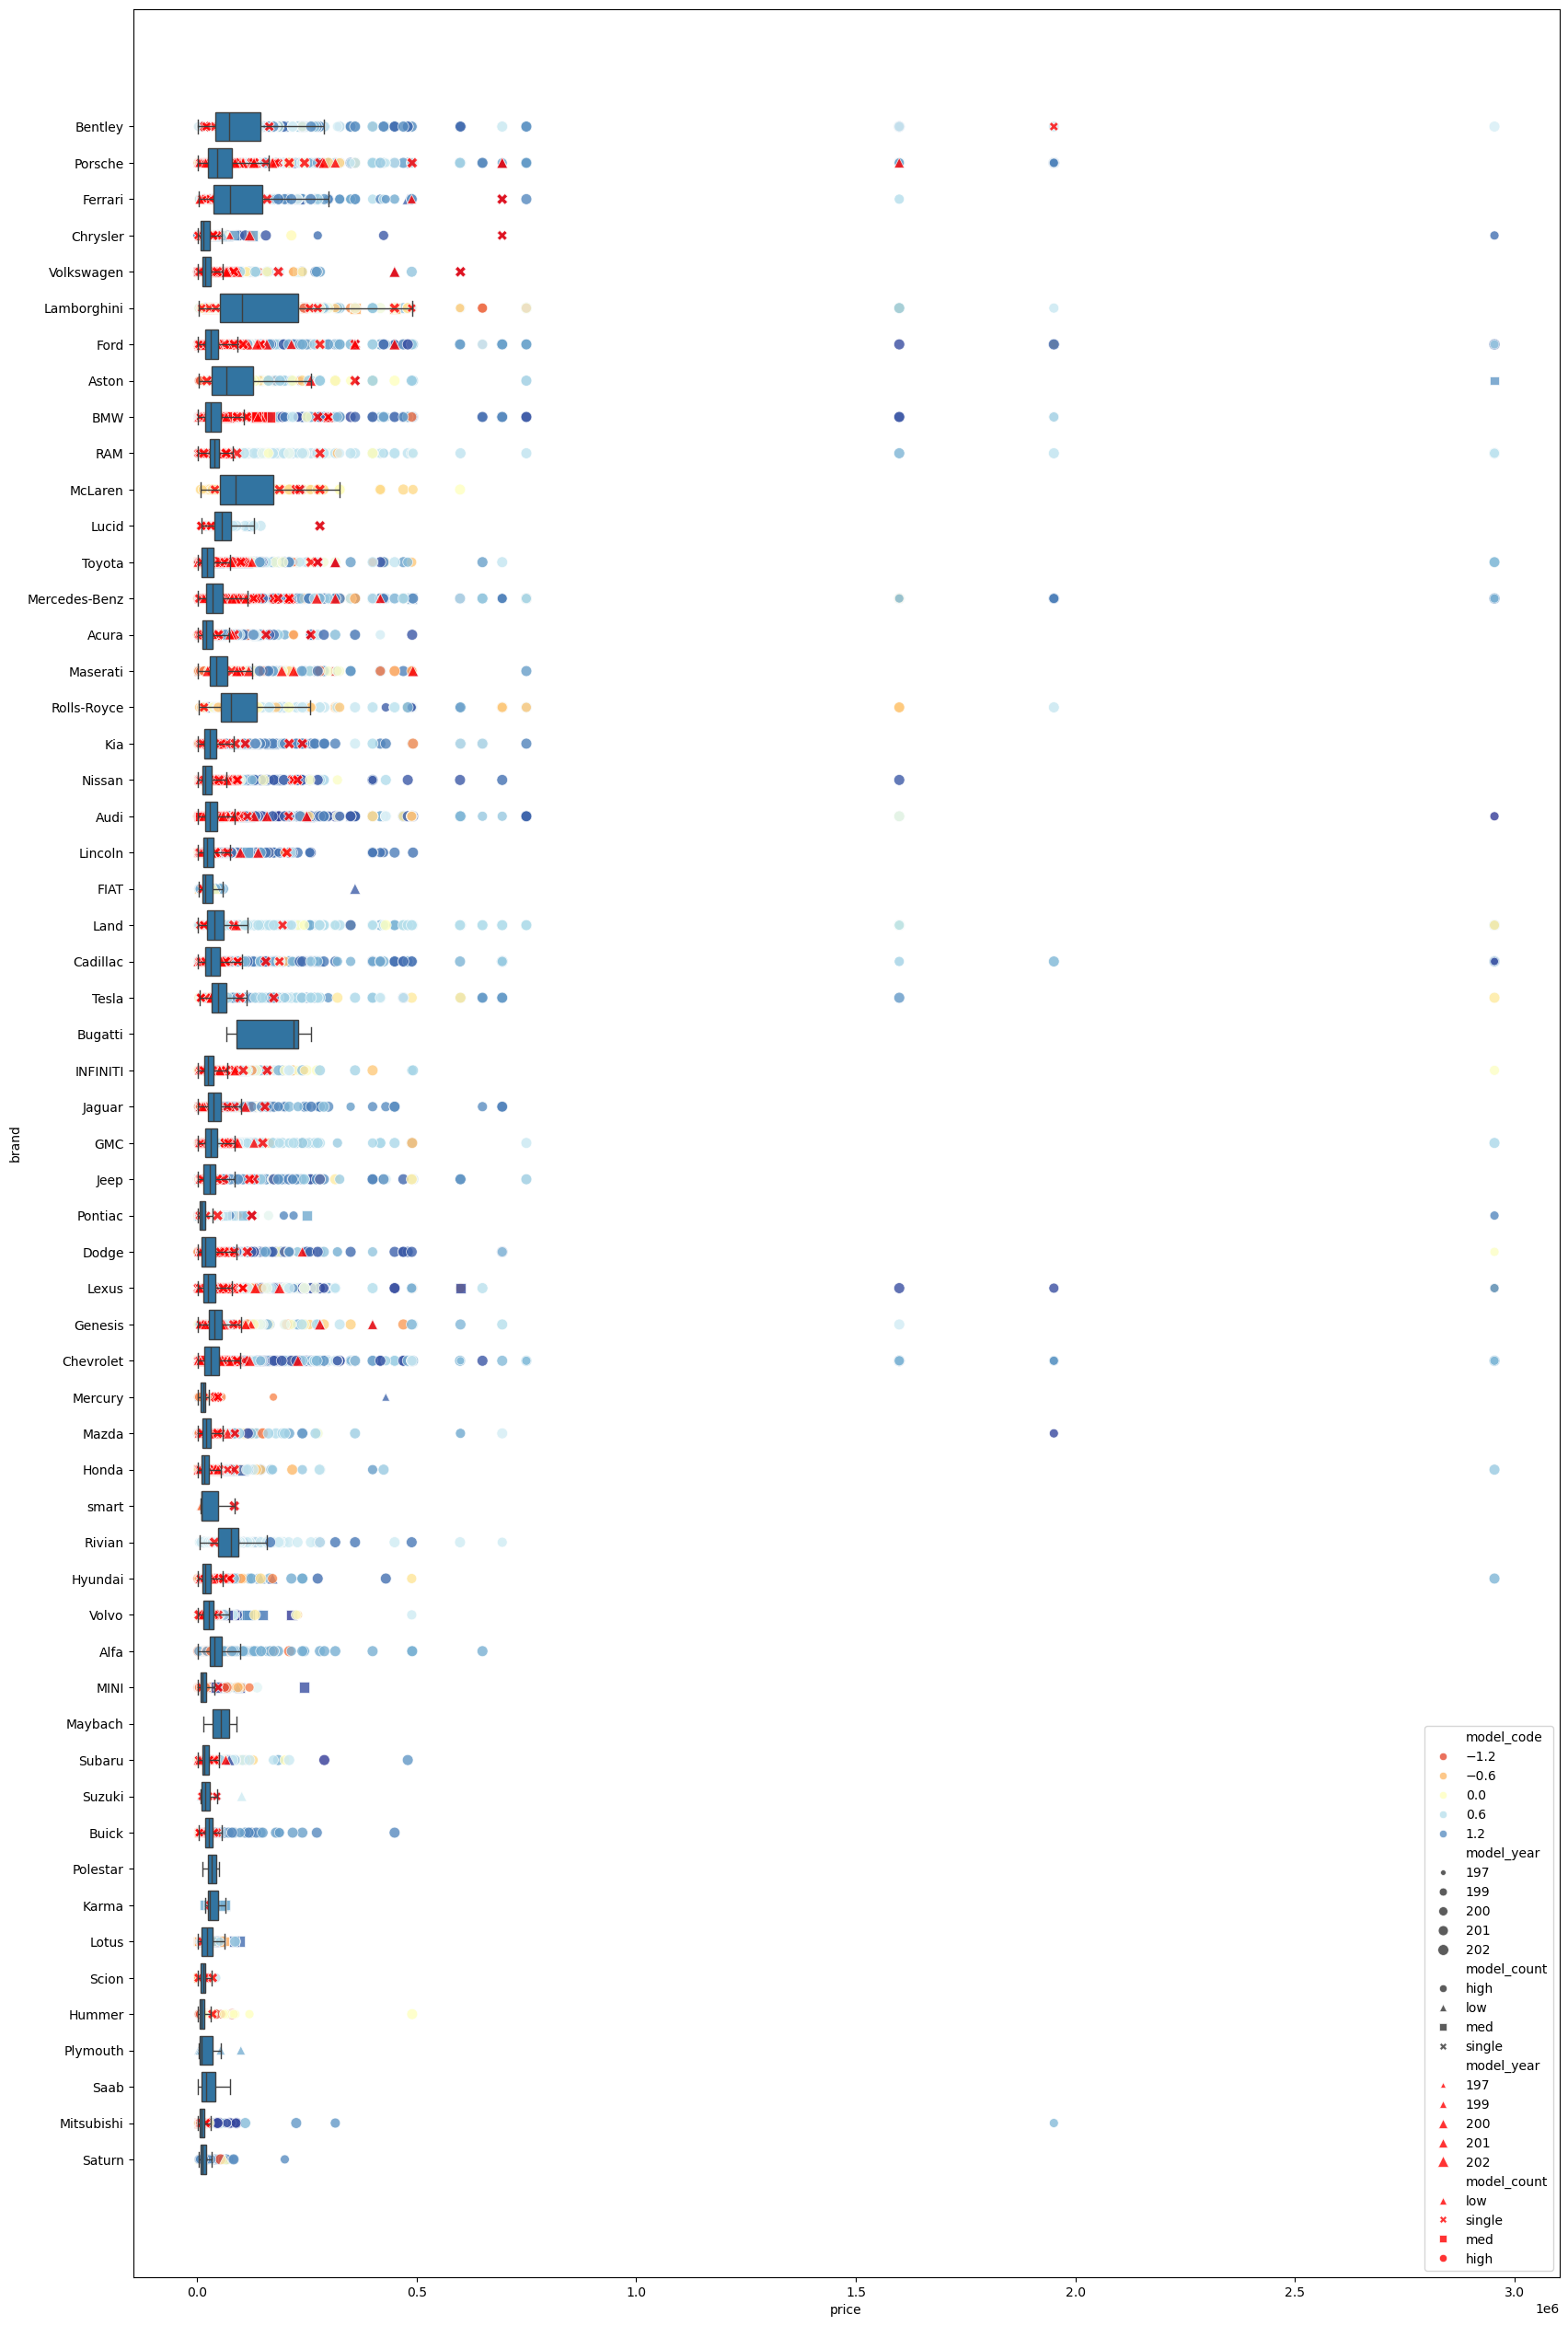

In [82]:
df_sorted = df.sort_values(by=['mean_price_model','brand','model_w\o_trim'],ascending=False)
shape_map = {'single':'X','low':'^','med':'s','high':'o'}
plt.figure(figsize = (20,32))
sns.boxplot(df_sorted,x = 'price' ,y= 'brand', showfliers = False)
sns.scatterplot(df_sorted,x = 'price' ,y= 'brand', hue = 'model_code', style = 'model_count', markers = shape_map, size = model_year_map, alpha = 0.8, palette= 'RdYlBu' )
sns.scatterplot(df_sorted[df_sorted['outlier'] == True],x = 'price' ,y= 'brand', color = 'red', style = 'model_count', markers = shape_map, size = model_year_map, alpha = 0.8, palette= 'RdYlBu' )

Distribution w/o brand-model outliers

<Axes: xlabel='price', ylabel='brand'>

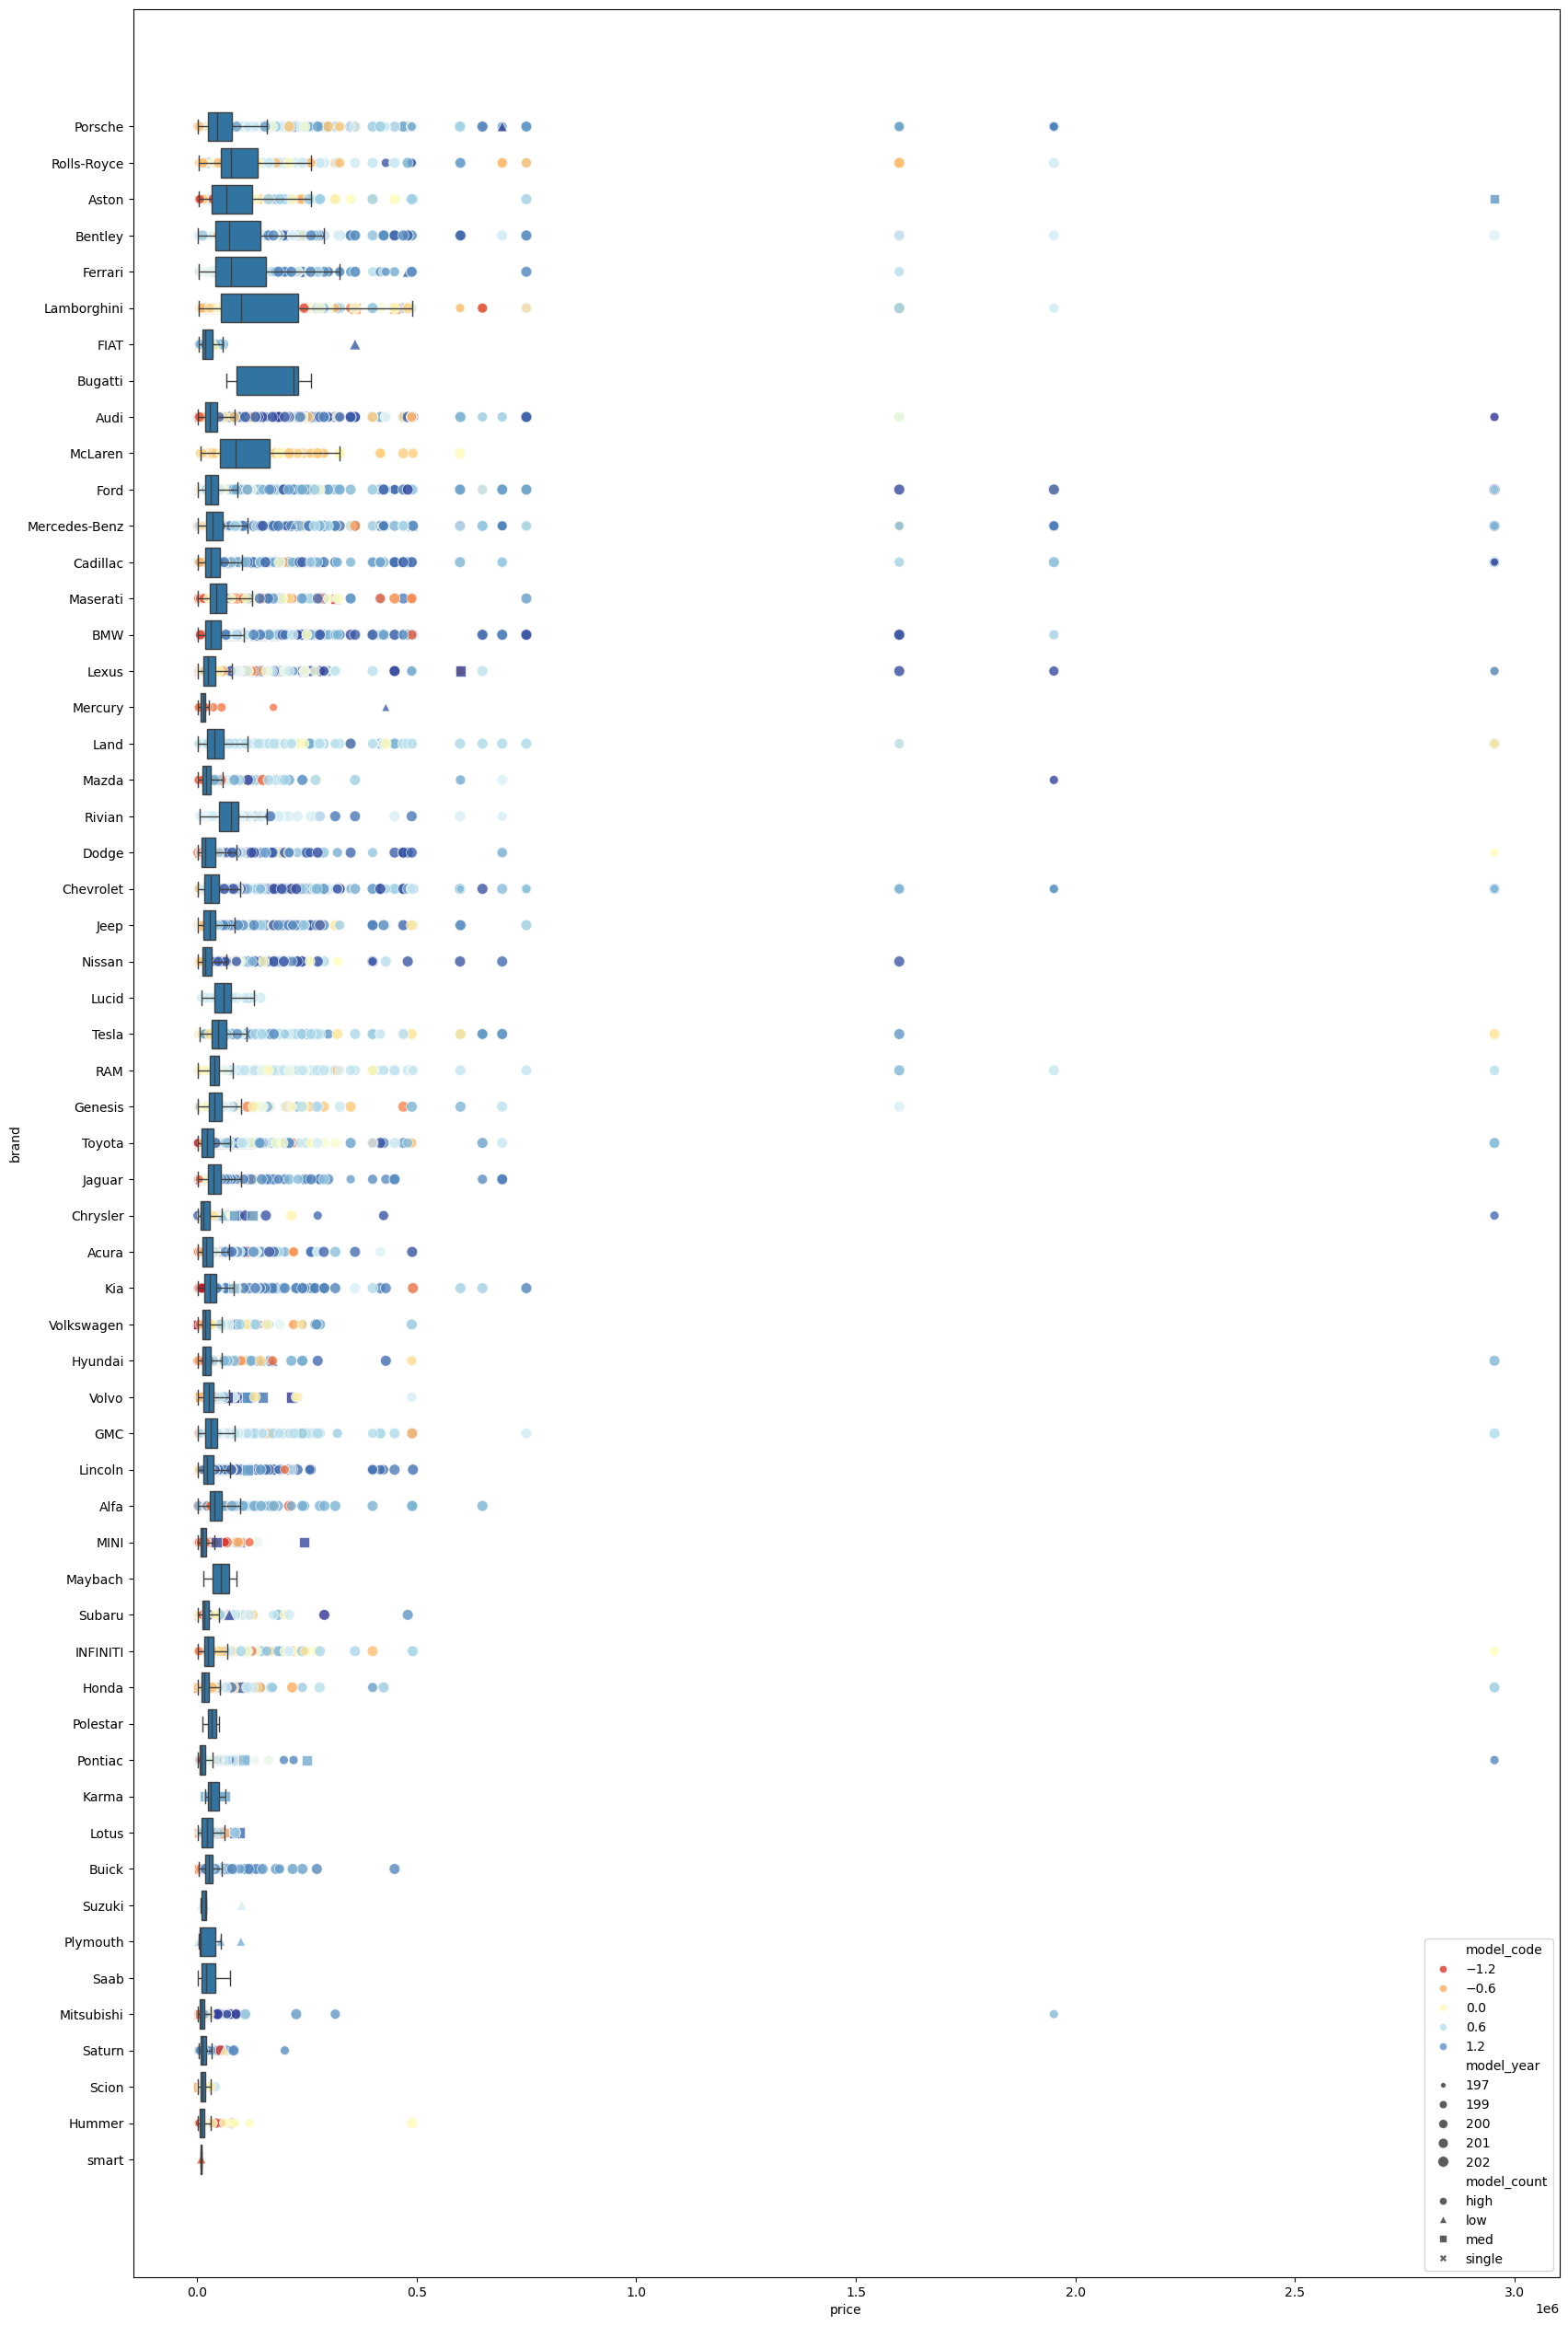

In [90]:
plt.figure(figsize = (20,32))
sns.boxplot(df_sorted[df_sorted['outlier']==False],x = 'price' ,y= 'brand', showfliers = False)
sns.scatterplot(df_sorted[df_sorted['outlier']==False],x = 'price' ,y= 'brand', hue = 'model_code', style = 'model_count', markers = shape_map, size = model_year_map, alpha = 0.8, palette= 'RdYlBu' )

In [125]:
df['outlier'] = (df['outlier'] == True) | (df['price'] > 1500000) # Assume cars with price greater than 1500000 as outliers

All outliers isolated on distribution of car prices for different brands

<Axes: xlabel='price', ylabel='brand'>

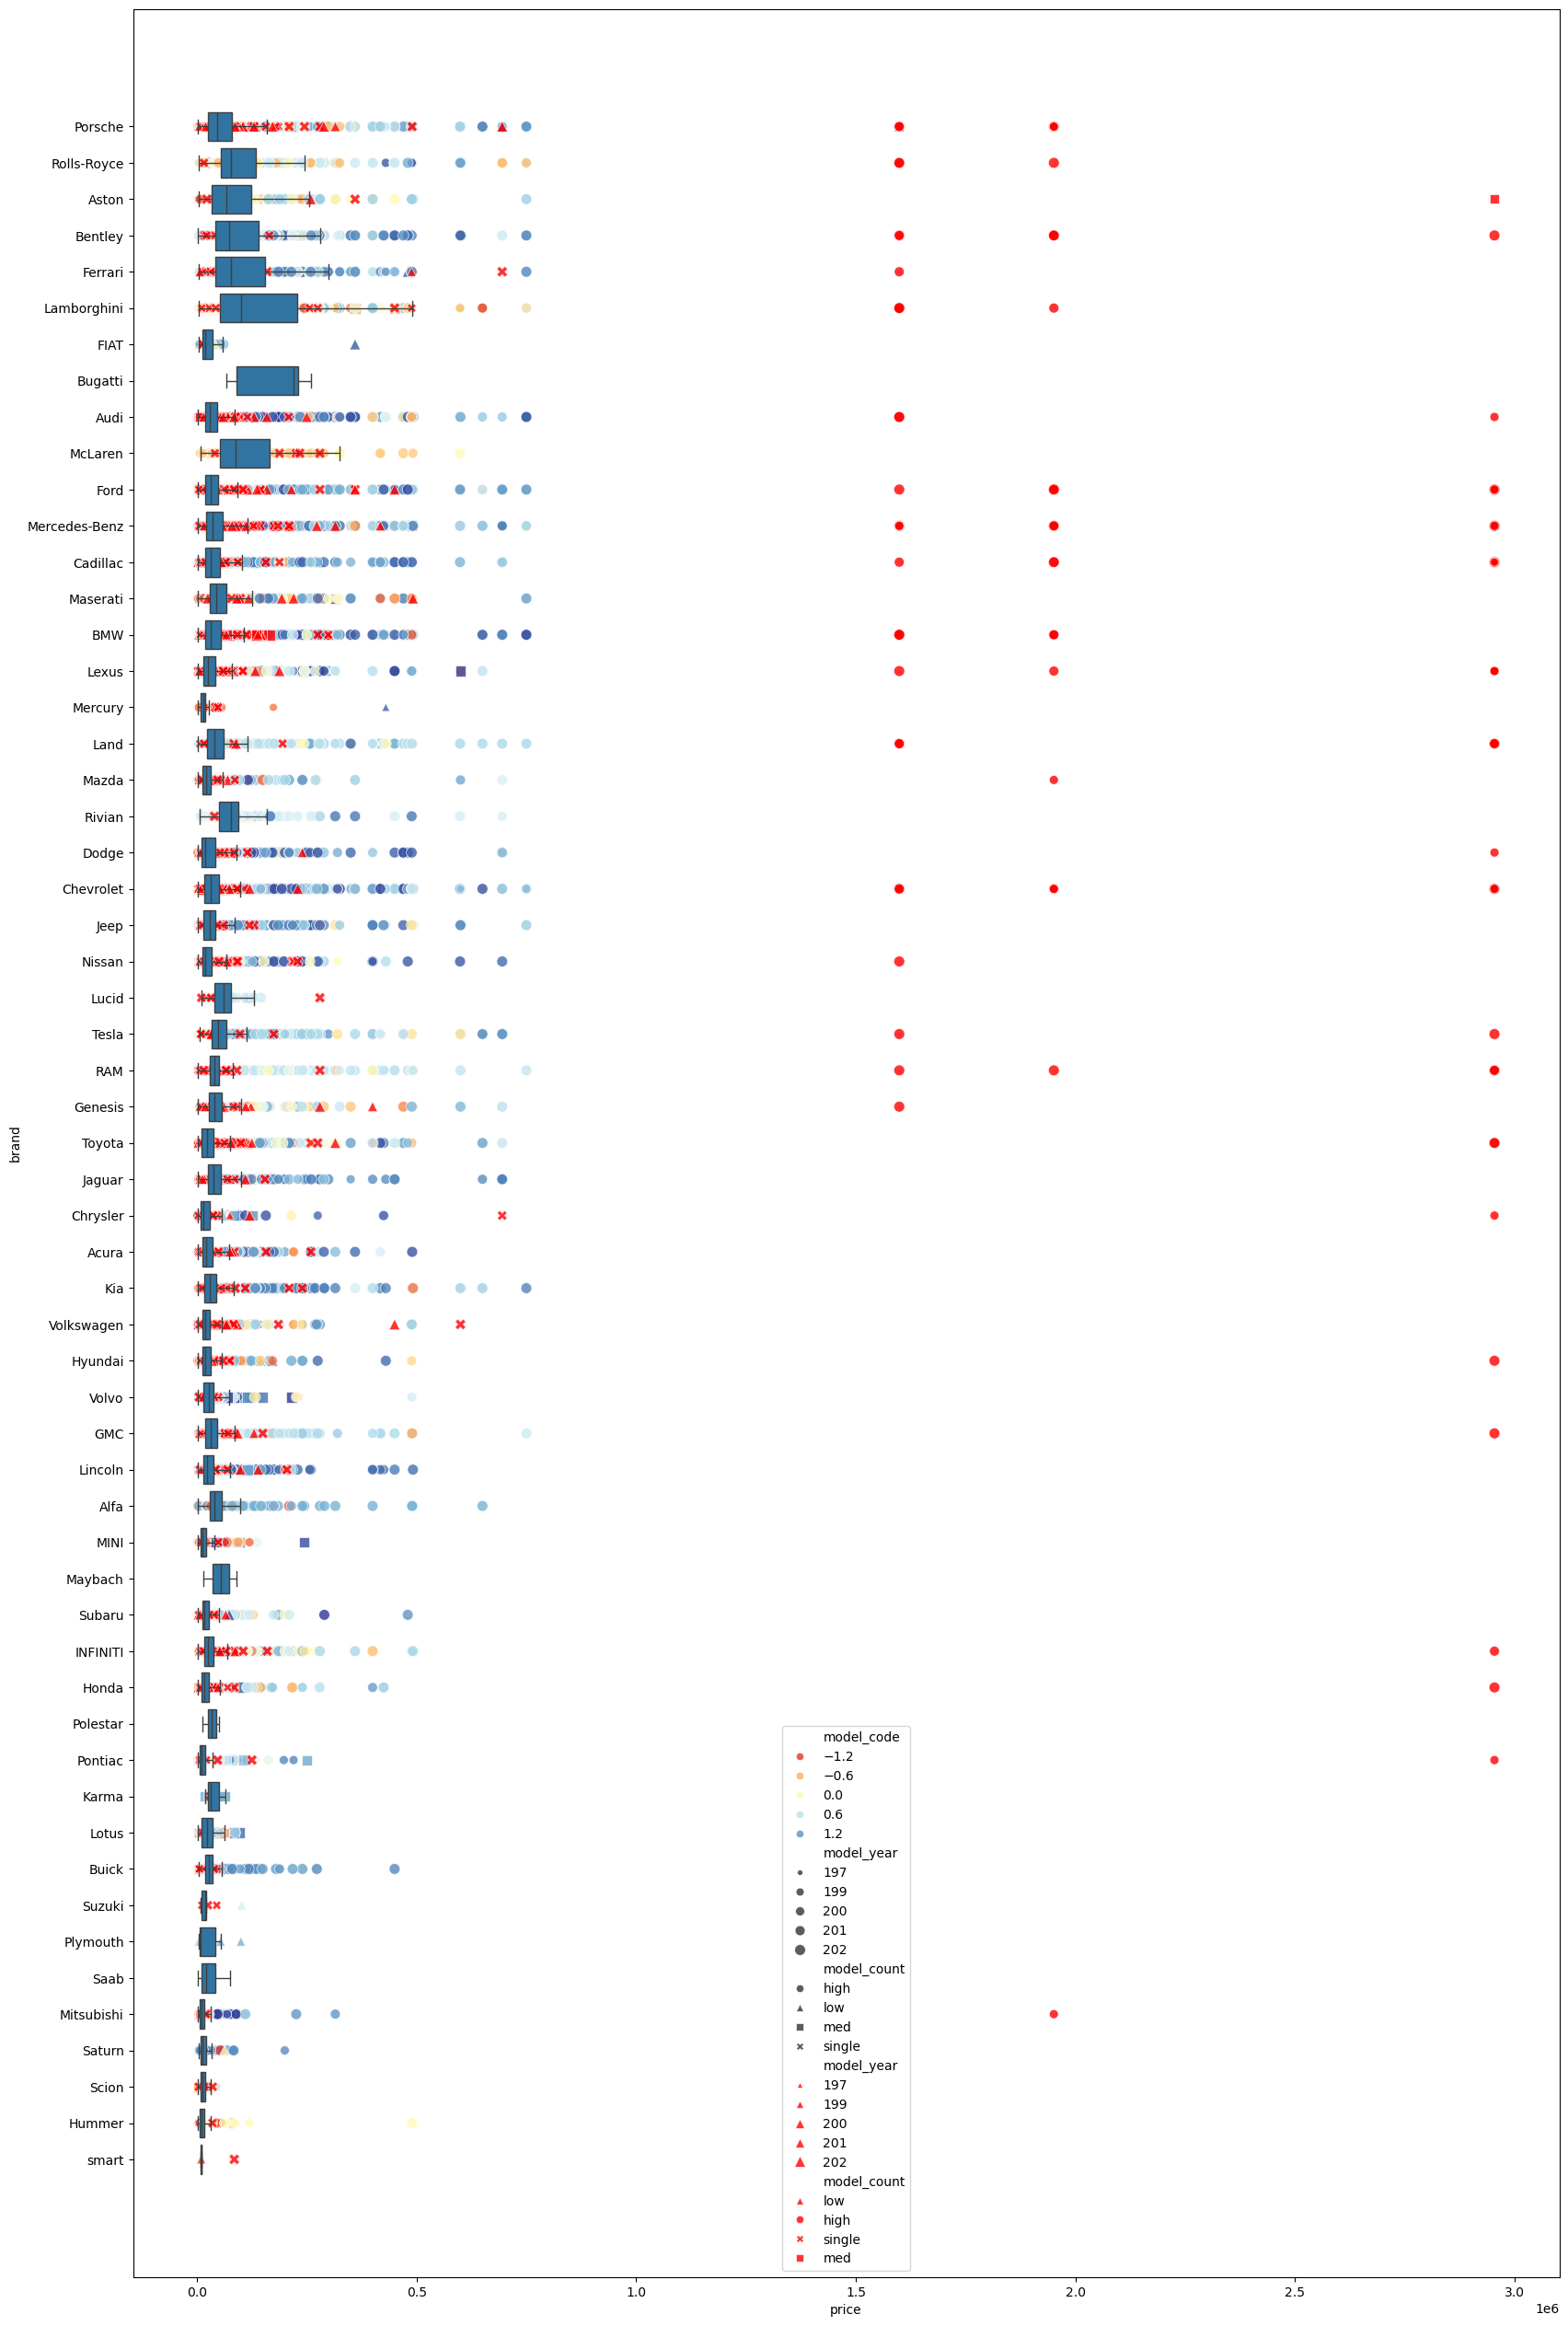

In [127]:
df_sorted = df.sort_values(by=['mean_price_model','brand','model_w\o_trim'],ascending=False)
plt.figure(figsize = (20,32))
sns.boxplot(df_sorted[df_sorted['outlier'] == False],x = 'price' ,y= 'brand', showfliers = False)
sns.scatterplot(df_sorted[df_sorted['outlier'] == False],x = 'price' ,y= 'brand', hue = 'model_code', style = 'model_count', markers = shape_map, size = model_year_map, alpha = 0.8, palette= 'RdYlBu' )
sns.scatterplot(df_sorted[df_sorted['outlier'] == True],x = 'price' ,y= 'brand', color = 'red', style = 'model_count', markers = shape_map, size = model_year_map, alpha = 0.8 )

Check for anomalous horse-power

<Axes: xlabel='hp_final', ylabel='brand'>

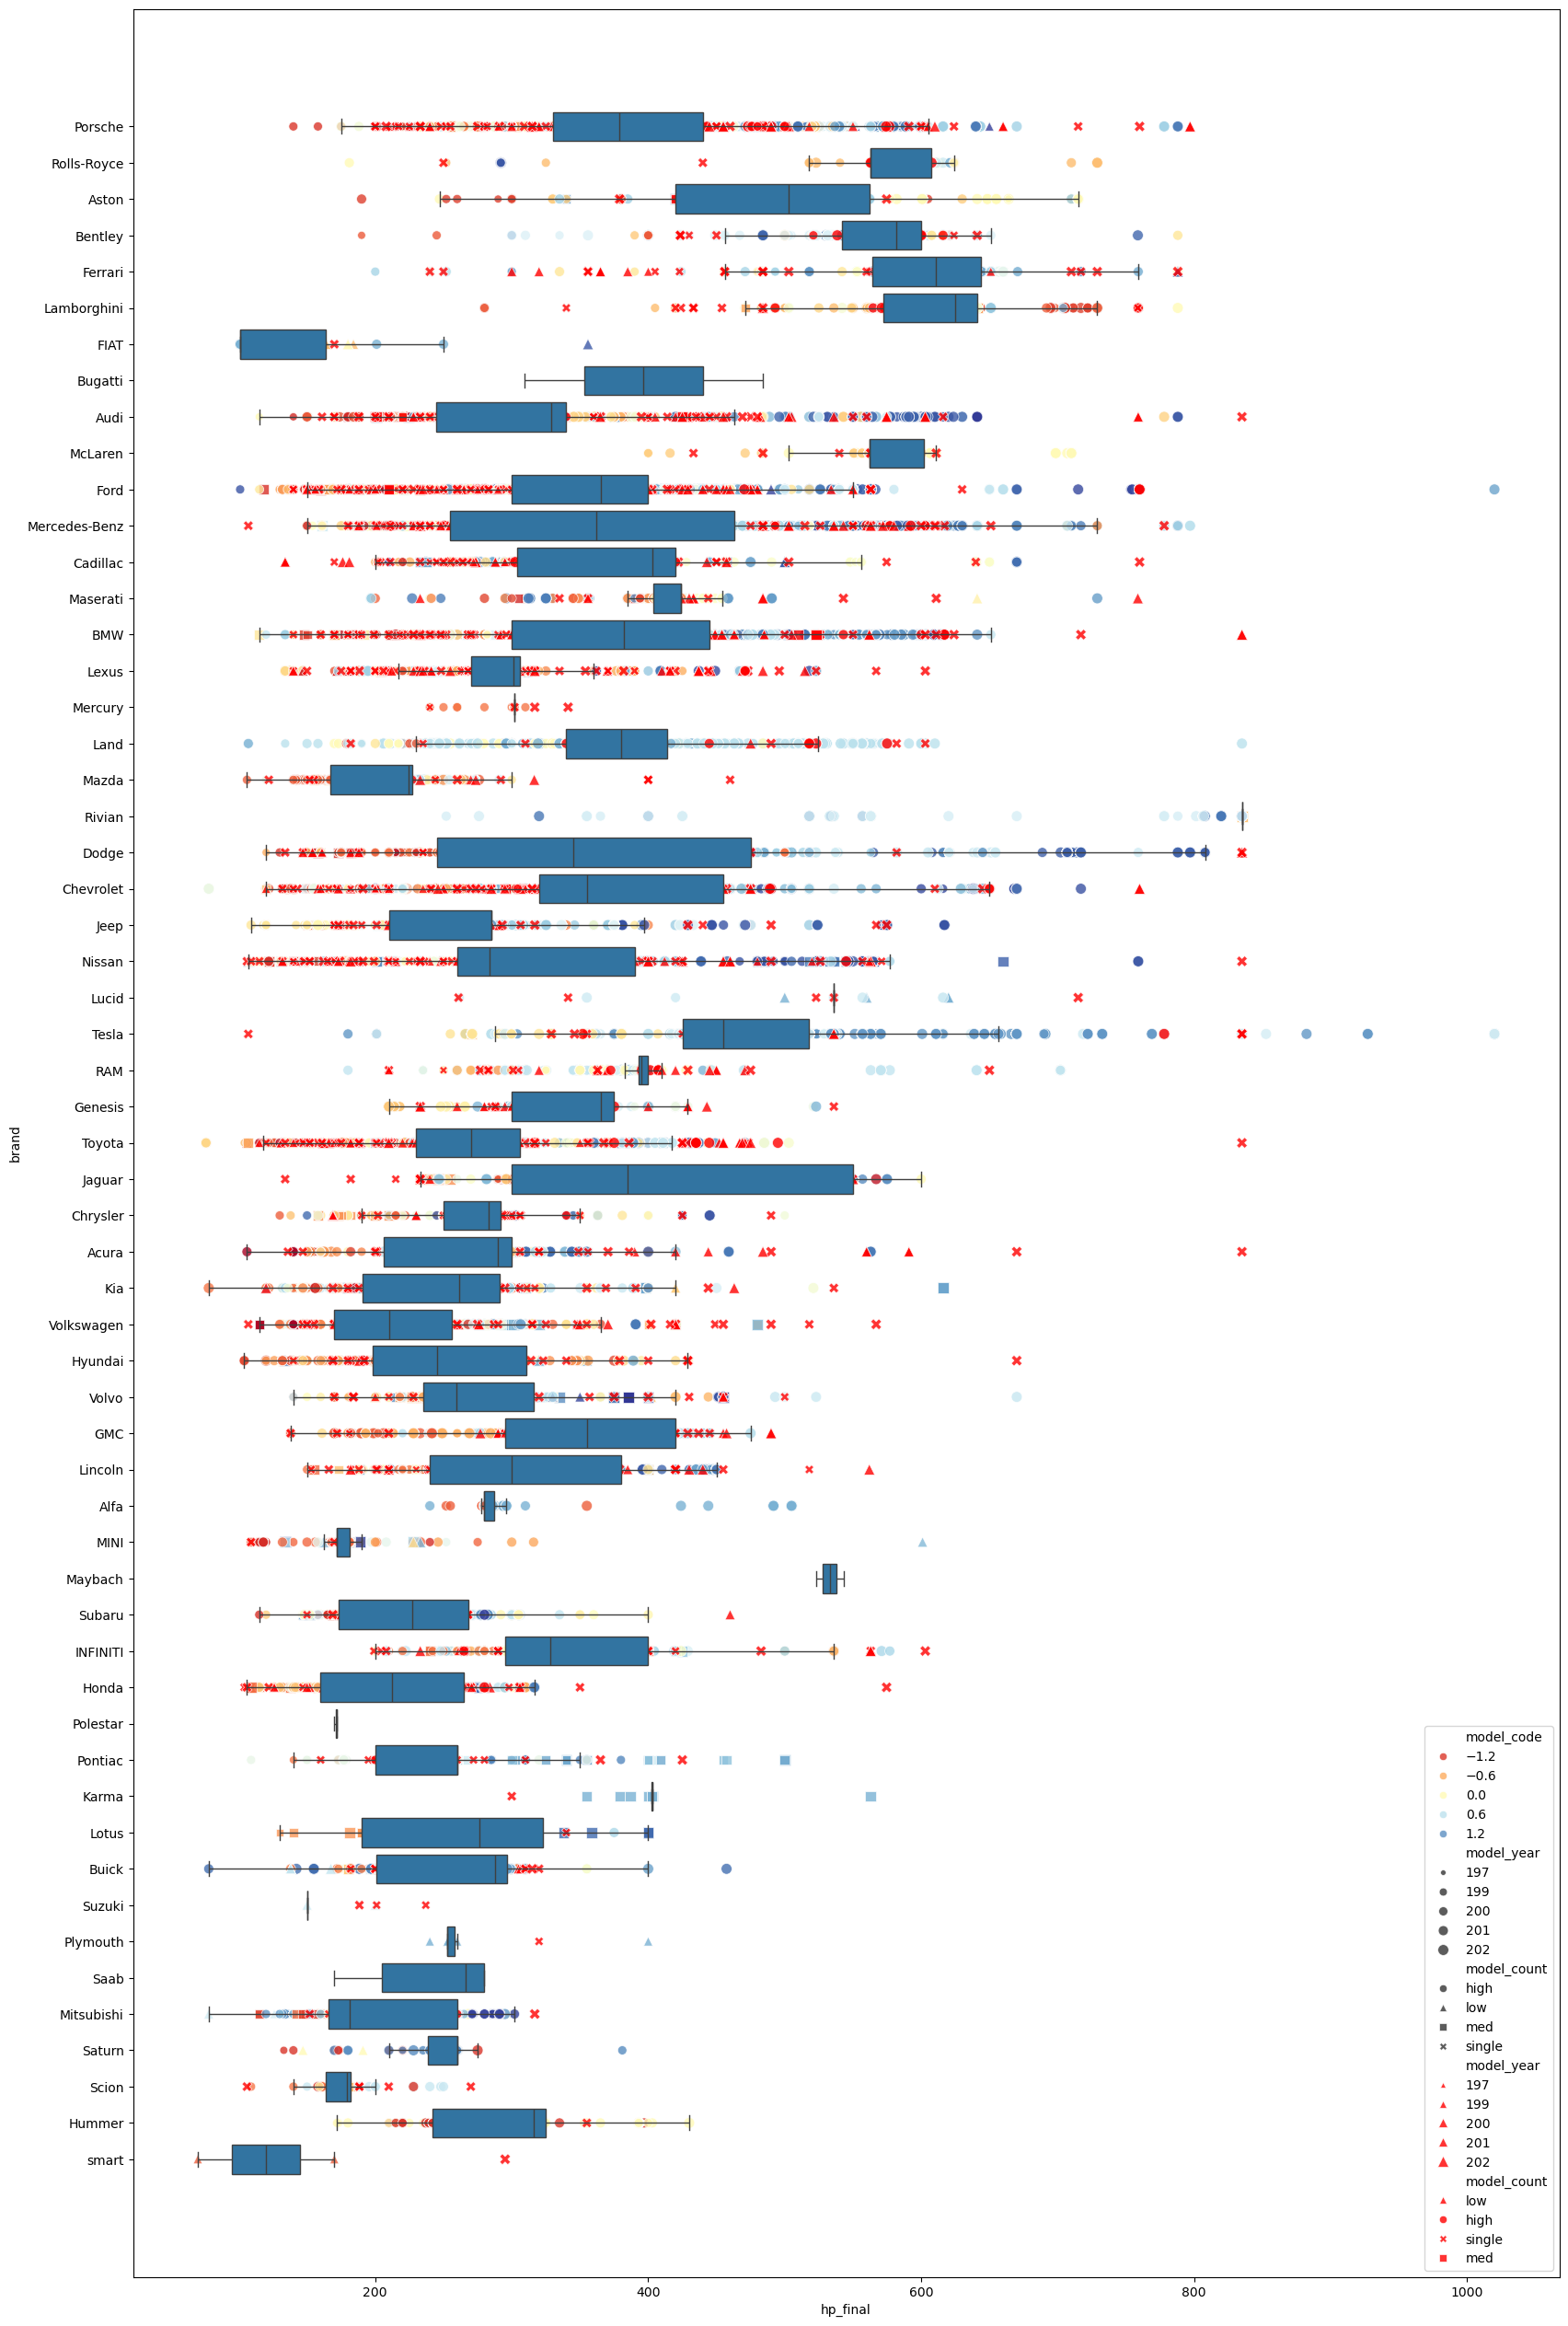

In [133]:
plt.figure(figsize = (20,32))
sns.boxplot(df_sorted[df_sorted['outlier'] == False],x = 'hp_final' ,y= 'brand', showfliers = False)
sns.scatterplot(df_sorted[df_sorted['outlier'] == False],x = 'hp_final' ,y= 'brand', hue = 'model_code', style = 'model_count', markers = shape_map, size = model_year_map, alpha = 0.8, palette= 'RdYlBu' )
sns.scatterplot(df_sorted[df_sorted['outlier'] == True],x = 'hp_final' ,y= 'brand', color = 'red', style = 'model_count', markers = shape_map, size = model_year_map, alpha = 0.8 )

Rivian, Tesla and Porsche has some wierd horse-power thing going on

In [138]:
df_sorted[(df_sorted['brand']=='Rivian') & ( df_sorted['outlier']==False) & (df_sorted['hp_final']!=835)][['model','engine','fuel_type', 'hp','hp_final']]

,model,engine,fuel_type,hp,hp_final
11216,R1S Launch Edition,400.0HP 5.6L 8 Cylinder Engine Gasoline Fuel,Gasoline,400.0,400.000000
24089,R1S Launch Edition,Electric,Gasoline,NaN,807.800000
33720,R1S Launch Edition,5.0L V8 32V PDI DOHC,Gasoline,NaN,819.813559
36838,R1S Launch Edition,320.0HP Electric Motor Electric Fuel System,Electric,320.0,320.000000
40466,R1S Launch Edition,3.0L V6 24V GDI DOHC Twin Turbo,Gasoline,NaN,807.800000
...,...,...,...,...,...
169021,R1S Adventure Package,536.0HP Electric Motor Electric Fuel System,Electric,536.0,536.000000
170502,R1S Adventure Package,563.0HP Electric Motor Electric Fuel System,Electric,563.0,563.000000
178245,R1S Adventure Package,533.0HP Electric Motor Electric Fuel System,Electric,533.0,533.000000
182865,R1S Adventure Package,518.0HP Electric Motor Electric Fuel System,Electric,518.0,518.000000


There seems to be a problem with the engine description for models, one that defenitely would extend to all models in the data. This pormpts further data cleaning

In [141]:
df_sorted.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'hp', 'engine_capacity', 'cylinders', 'transmission_type',
       'model_w\o_trim', 'trim', 'ext_col_len', 'base_ext_color',
       'int_col_len', 'base_int_color', 'hp_x', 'hp_y', 'hp_z', 'hp_zz',
       'hp_final', 'mean_price_model', 'model_count', 'brand_code',
       'model_code', 'temp_model', 'outlier'],
      dtype='object')

In [142]:
model_grp2 = df_sorted[df_sorted['outlier']==False][['model_w\o_trim','engine']].groupby(['model_w\o_trim','engine']).size().reset_index().rename(columns = {0:'size'})
model_grp2 

,model_w\o_trim,engine,size
0,Acura ILX,150.0HP 1.4L 4 Cylinder Engine Gasoline Fuel,1
1,Acura ILX,150.0HP 2.4L 4 Cylinder Engine Gasoline Fuel,16
2,Acura ILX,160.0HP 2.4L 4 Cylinder Engine Gasoline Fuel,2
3,Acura ILX,2.4 Liter,6
4,Acura ILX,2.4L I4 16V GDI DOHC,4
...,...,...,...
13344,Volvo XC90 T6,316.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,93
13345,Volvo XC90 T6,670.0HP Electric Motor Electric Fuel System,1
13346,Volvo XC90 T6,–,1
13347,smart ForTwo,170.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,1


This is messy, but for the purposes of this project we can consider this to be the ground truth.

Lets remove unwanted helper columns

In [143]:
df_sorted.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'hp', 'engine_capacity', 'cylinders', 'transmission_type',
       'model_w\o_trim', 'trim', 'ext_col_len', 'base_ext_color',
       'int_col_len', 'base_int_color', 'hp_x', 'hp_y', 'hp_z', 'hp_zz',
       'hp_final', 'mean_price_model', 'model_count', 'brand_code',
       'model_code', 'temp_model', 'outlier'],
      dtype='object')

In [165]:
features_1 = ['brand', 'model_year', 'milage', 'fuel_type', 'accident', 'clean_title', 'engine_capacity', 'cylinders', 'transmission_type','model_w\o_trim', 'base_ext_color', 'base_int_color', 'hp_final','price']
df2 = df_sorted[df_sorted['outlier']==False].copy()
df2 = df2[features_1]
df2 = df2.dropna()

df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171919 entries, 20128 to 186554
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   brand              171919 non-null  object 
 1   model_year         171919 non-null  int64  
 2   milage             171919 non-null  int64  
 3   fuel_type          171919 non-null  object 
 4   accident           171919 non-null  object 
 5   clean_title        171919 non-null  object 
 6   engine_capacity    171919 non-null  float64
 7   cylinders          171919 non-null  float64
 8   transmission_type  171919 non-null  object 
 9   model_w\o_trim     171919 non-null  object 
 10  base_ext_color     171919 non-null  object 
 11  base_int_color     171919 non-null  object 
 12  hp_final           171919 non-null  float64
 13  price              171919 non-null  int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 19.7+ MB


In [166]:
y = df2.pop('price')
X = df2

continuous =  X.select_dtypes(include=['number'])
one_hot_data =  X.select_dtypes(include=['object']).drop(columns = ['brand','model_w\o_trim'])

from sklearn.preprocessing import StandardScaler, TargetEncoder, OneHotEncoder
s_scaler = StandardScaler()
scaled_continous = s_scaler.fit_transform(continuous)
scaled_continous = pd.DataFrame(scaled_continous, columns = s_scaler.get_feature_names_out())

oh_encoder = OneHotEncoder(sparse_output=False)
encoded_oh_data = oh_encoder.fit_transform(one_hot_data)
encoded_oh_data = pd.DataFrame(encoded_oh_data, columns =oh_encoder.get_feature_names_out())


In [169]:
te = TargetEncoder()
encoded_nominal = te.fit_transform(X[['brand']],y)
encoded_nominal = pd.Series(encoded_nominal, name = 'brand')


MemoryError: Unable to allocate 2.00 GiB for an array with shape (171919, 1562) and data type int64

In [ ]:

X_new = pd.concat([scaled_continous,encoded_oh_data ,encoded_nominal], axis = 1)
X_new.info()

In [ ]:
# brand_count = df[['brand','price']].groupby('brand').count().reset_index().rename(columns = {'price':'count'})
# brand_price_mean = df[['brand','price']].groupby('brand').mean().reset_index().rename(columns = {'price':'mean'})
# brand_price_median = df[['brand','price']].groupby('brand').median().reset_index().rename(columns = {'price':'median'})
# brand_price_min = df[['brand','price']].groupby('brand').min().reset_index().rename(columns = {'price':'min'})
# brand_price_max = df[['brand','price']].groupby('brand').max().reset_index().rename(columns = {'price':'max'})

# brand_segment = brand_count.merge(brand_price_mean, on = 'brand' ).merge(brand_price_median, on = 'brand' ).merge(brand_price_min, on = 'brand' ).merge(brand_price_max, on = 'brand' )
# brand_segment

Let's implement ANOVA from scratch

In [ ]:
# def anova_test(X:pd.Series,y:pd.Series):
#     classes = X.unique()
#     ssw = 0
#     ssb = 0
#     for i,c in enumerate(classes):
#         class_values = y[X == c] 
#         class_mean = np.mean(class_values)
#         ssw += sum((class_values - class_mean)**2)
#         ssb += len(class_values) * (class_mean- np.mean(y))**2
#     dfb = len(classes) - 1
#     dfw = len(y) - len(classes)
#     msb = ssb/dfb
#     msw = ssw/dfw
#     f = msb/msw 
#     return f

# anova_test(df['hp_class'], df['price'])

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 [Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8'),
  Text(9.0, 0, '9')])

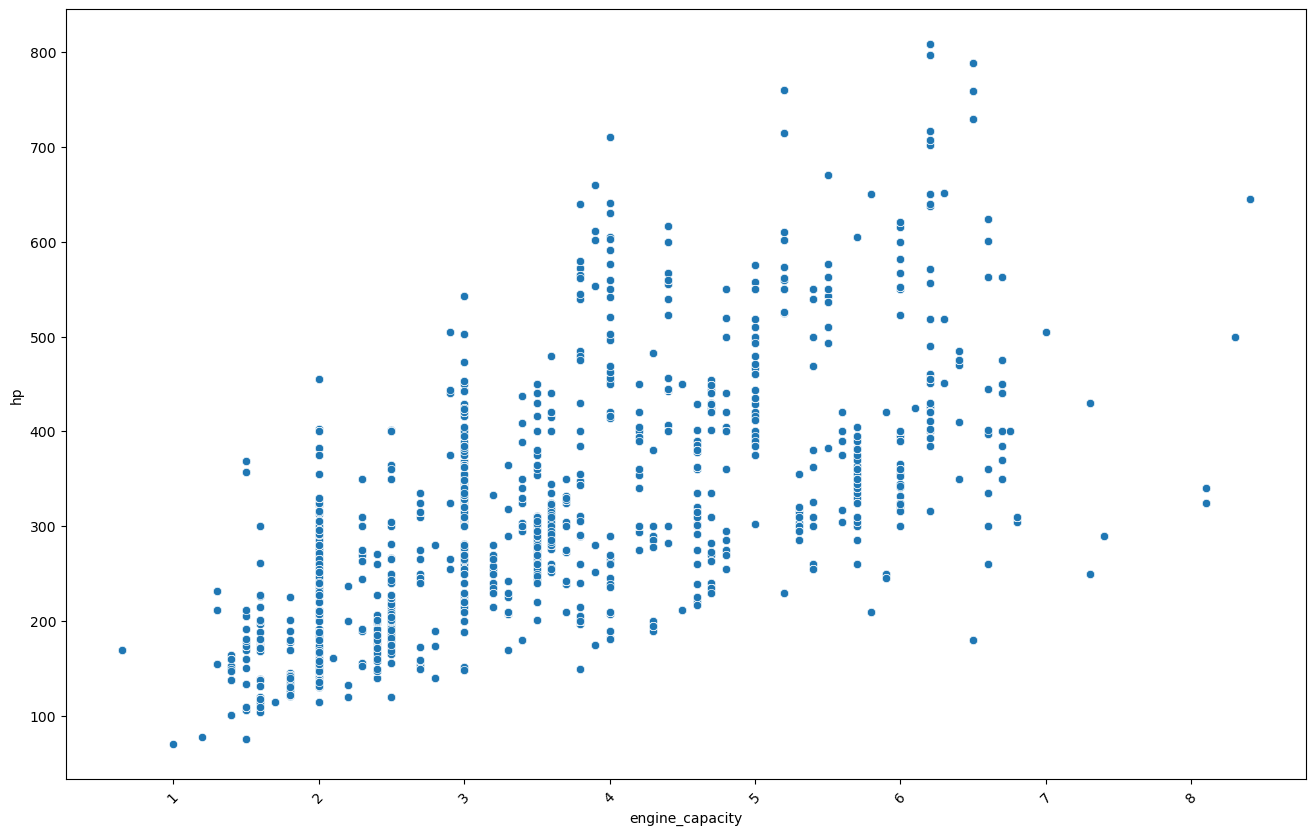

In [274]:
plt.figure(figsize=(16,10))
sns.scatterplot(x = df['engine_capacity'].astype('float'), y = df['hp'])
plt.xticks(rotation = 45)

In [279]:
df[(df['engine_capacity'].astype('float')>6) & (df['hp'].astype('float')<200)]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,model_w\o_trim,trim,hp_class,ext_col_len,base_ext_color,int_col_len,base_int_color,hp_x,hp_y,hp_final
6733,6733,Chevrolet,Express 3500 Base,2010,190321,Diesel,180.0HP 6.5L 8 Cylinder Engine Diesel Fuel,4-Speed A/T,Gray,Gray,...,Express 3500,Base,class_2,1,Gray,1,Gray,NaN,NaN,180.0
28115,28115,Chevrolet,Tahoe Base,2004,189719,Diesel,180.0HP 6.5L 8 Cylinder Engine Diesel Fuel,A/T,Black,Gray,...,Tahoe,Base,class_2,1,Black,1,Gray,NaN,258.333333,180.0
58874,58874,Chevrolet,Tahoe Base,1997,215000,Diesel,180.0HP 6.5L 8 Cylinder Engine Diesel Fuel,4-Speed A/T,White,Gray,...,Tahoe,Base,class_2,1,White,1,Gray,NaN,258.333333,180.0
116856,116856,Chevrolet,Impala Base,1998,139000,Diesel,180.0HP 6.5L 8 Cylinder Engine Diesel Fuel,A/T,Red,Beige,...,Impala,Base,class_2,1,Red,1,Beige,NaN,NaN,180.0
170385,170385,BMW,Excursion Limited,2004,125519,Diesel,180.0HP 6.5L 8 Cylinder Engine Diesel Fuel,A/T,White,Beige,...,Excursion,Limited,class_2,1,White,1,Beige,NaN,NaN,180.0


In [264]:
df[df['brand']=='Tesla'][['brand','model','hp','hp_x','hp_y']]

,brand,model,hp,hp_x,hp_y
11,Tesla,Model S P100D,NaN,484.000000,519.453782
32,Tesla,Model S P100D,518.0,517.632911,519.453782
51,Tesla,Model 3 Long Range,NaN,353.041667,330.124402
52,Tesla,Model X 75D,518.0,NaN,516.278846
161,Tesla,Model S Long Range,670.0,611.285714,626.638889
...,...,...,...,...,...
188231,Tesla,Model 3 Performance,455.0,455.000000,439.108108
188302,Tesla,Model Y Performance,455.0,454.115942,454.602597
188339,Tesla,Model S 100D,518.0,516.065934,513.509554
188380,Tesla,Model S Performance,778.0,NaN,705.434783


In [305]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 188533 non-null  int64  
 1   brand              188533 non-null  object 
 2   model              188533 non-null  object 
 3   model_year         188533 non-null  int64  
 4   milage             188533 non-null  int64  
 5   fuel_type          188533 non-null  object 
 6   engine             188533 non-null  object 
 7   transmission       188533 non-null  object 
 8   ext_col            188533 non-null  object 
 9   int_col            188533 non-null  object 
 10  accident           188533 non-null  object 
 11  clean_title        188533 non-null  object 
 12  price              188533 non-null  int64  
 13  hp                 155274 non-null  float64
 14  engine_capacity    181835 non-null  object 
 15  cylinders          174150 non-null  object 
 16  tr

In [306]:
df.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'hp', 'engine_capacity', 'cylinders', 'transmission_type',
       'model_w\o_trim', 'trim', 'hp_class', 'ext_col_len', 'base_ext_color',
       'int_col_len', 'base_int_color', 'hp_x', 'hp_y', 'hp_final', 'hp_z',
       'hp_zz'],
      dtype='object')

In [309]:
init_columns = ['brand','model_w\o_trim', 'model_year', 'mileage', 'fuel_type', 'accident','clean_title', 'hp_final','base_ext_color', 'base_int_color', 'price']
df2 = df[['brand','model_w\o_trim', 'model_year', 'milage', 'fuel_type', 'accident','clean_title', 'hp_final','base_ext_color', 'base_int_color', 'price']].dropna().copy()

X = df2.copy()
y = X.pop('price')


X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188278 entries, 0 to 188532
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   brand           188278 non-null  object 
 1   model_w\o_trim  188278 non-null  object 
 2   model_year      188278 non-null  int64  
 3   milage          188278 non-null  int64  
 4   fuel_type       188278 non-null  object 
 5   accident        188278 non-null  object 
 6   clean_title     188278 non-null  object 
 7   hp_final        188278 non-null  float64
 8   base_ext_color  188278 non-null  object 
 9   base_int_color  188278 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 15.8+ MB


In [98]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import OneHotEncoder

oh_encoder = OneHotEncoder(sparse_output=False)
one_hot_hp = oh_encoder.fit_transform(df[['base_ext_color']])
f_stats, p_values = f_classif(one_hot_hp, df['price'])

In [101]:
p_values

array([7.16516297e-045, 4.83386119e-060, 1.25748860e-031, 9.22579213e-001,
       4.97887346e-114, 1.12152902e-321, 2.43915217e-137, 0.00000000e+000,
       4.21029068e-015, 9.99999792e-001, 1.29107916e-112, 1.19291172e-311,
       2.36426951e-156, 7.83000008e-001])

<Axes: >

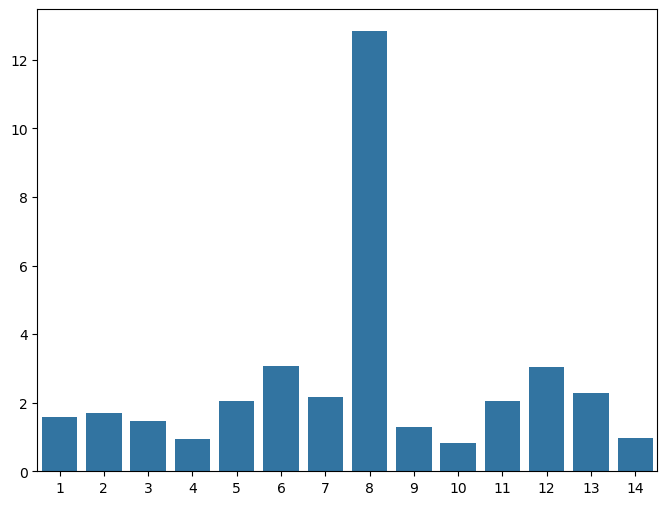

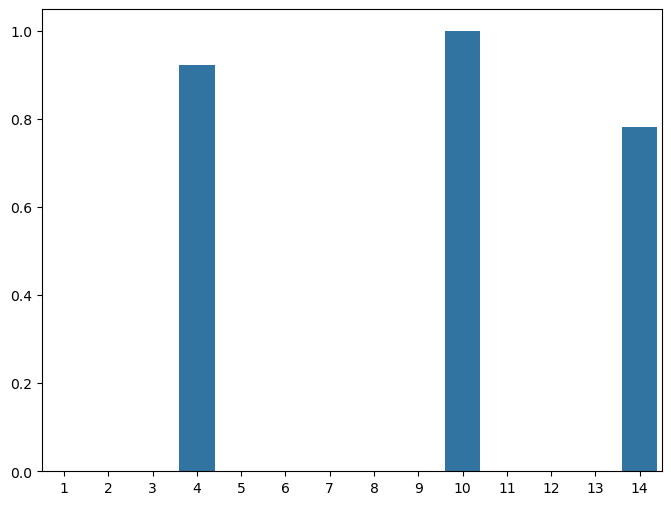

In [105]:
plt.figure(figsize=((8,6)))
sns.barplot(x = range(1,len(f_stats)+1), y = f_stats)
plt.figure(figsize=((8,6)))
sns.barplot(x = range(1,len(p_values)+1), y = p_values)